# Topic Modeling and Gibbs Sampling


Задача: описать текст через распределение весов по некоторому фиксированному набору топиков (тегов). Например, для набора тегов Политика, Военные сражения, Спорт, Интернет, Драма представить роман "Война и мир" как вектор (0.3, 0.2, 0, 0, 0.5), а статью в газете про допинг в велоспорте как вектор (0.1, 0, 0.7, 0, 0.2).

Для чего, например, это нужно: имея векторное представление для текстов, тексты можно сравнивать, рекомендовать похожие.

Условие: даны только набор текстов и количество тем.

# Немного теории


Немного теории
Будем представлять текст как неупорядоченный набор слов (Bag-of-words model). Предположим, что имеется K тегов и для каждого тега выбрано распределение $\phi_k$ над списком всевозможных слов (словарем из N слов). По сути, каждое $\phi_k$ - это вектор длины N из неотрицательных величин, в сумме дающих 1. Вектора $\phi_k$ независимы и моделируются распредеделением Дирихле $Dir(\beta)$. Теперь, чтобы собрать текст d из $n$ слов, будем действовать по следующей схеме:

1)выберем распредление для тегов $\theta_d$. Вновь, $\theta_d$ - это вектор длины K из неотрицательных величин, в сумме дающих 1. Поэтому естественно брать $\theta_d \sim Dir(\theta | \alpha)$
2)Для i от 1 до n:

2.1)выберем тег $z_i$ согласно распределению $\theta_d$
2.2)выберем слово $w_i$ из распределения для данного тега, т.е. $w_i \sim \phi_{z_i}$
2.3)добавляем слово $w_i$ в текст.


Полученная модель называется моделью LDA (Latent Dirichlet Allocation). Описанная схема задает совместное распределение скрытых и наблюдаемых параметров по всем текстам корпуса размера M в виде:

$p(\textbf{w}, \textbf{z}, \theta, \phi | \alpha, \beta) = Dir(\theta | \alpha) Dir(\phi|\beta)Cat(\textbf{z}|\theta)Cat(\textbf{w}|\phi_z)$.

Здесь $\textbf{w}$ и $\textbf{z}$ обозначают вектора слов и тегов по всем текстам, $\theta$ - набор из $\theta_d$ для каждого документа (матрица $M\times K$), $\phi$ - набор из $\phi_k$ для каждого тега (матрица $K\times N$).

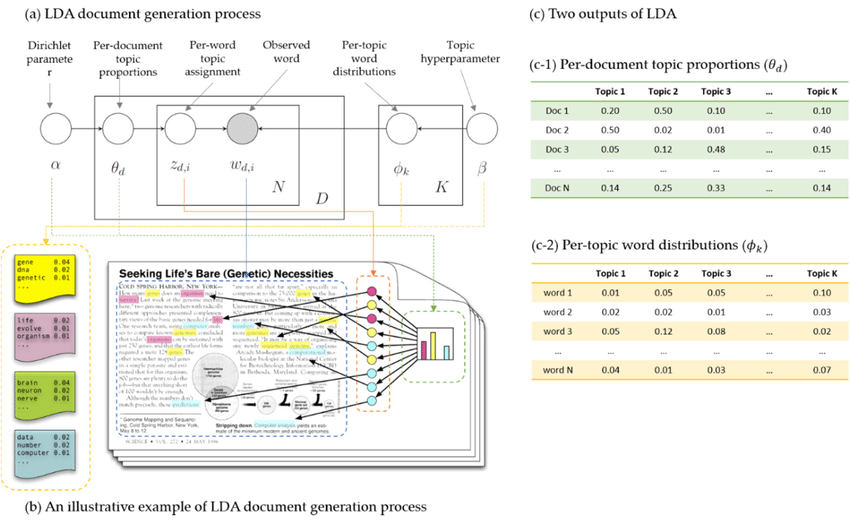


Наша задача - восстановить распределение $p(\textbf{z}, \theta, \phi | \textbf{w}, \alpha, \beta)$.

Немного упростим жизнь, и поставим себе задачей восстановить распределение $p(\textbf{z} | \textbf{w}, \alpha, \beta) = \int\int p(\textbf{z}, \theta, \phi | \textbf{w}, \alpha, \beta)\textrm{d}\theta\textrm{d}\phi$.

В этот момент на помощь приходить алгоритм Gibbs Sampling. Напомним, для оценки набора парамеров $\textbf{z} = (z_1, z_2, ..., z_m)$ используется схема:

$z_i^{(t)} \sim p(z_i^{(t)}\ | \ z_1=z_1^{t}, ..., z_{i-1}=z_{i-1}^{t},
z_{i+1}=z_{i+1}^{t-1}, z_{m}=z_{m}^{t-1})$.

Условные распределения выводятся так. Сначала замечаем, что

$p(z_i|\textbf{z}_{\hat{i}}, \textbf{w}, \alpha, \beta) = \frac{p(z_i,\textbf{z}_{\hat{i}}, \textbf{w}| \alpha, \beta)}{p(\textbf{z}_{\hat{i}}, \textbf{w}| \alpha, \beta)}  = \frac{p(\textbf{z}, \textbf{w}| \alpha, \beta)}{p(\textbf{z}_{\hat{i}}, \textbf{w}_{\hat{i}}| \alpha, \beta)  p(w_i|\alpha, \beta)}$.

Здесь $\textbf{z}_{\hat{i}}$, $\textbf{w}_{\hat{i}}$ - вектора без $i$-oй копмоненты.

Далее расписываем:

$p(\textbf{z}, \textbf{w}| \alpha, \beta) = \int\int p(\textbf{z}, \textbf{w}, \theta, \phi| \alpha, \beta)\textrm{d}\theta\textrm{d}\phi = \int\int Dir(\theta | \alpha) Dir(\phi|\beta)Cat(\textbf{z}|\theta)Cat(\textbf{w}|\phi_z)\textrm{d}\theta\textrm{d}\phi = 
\int Dir(\theta | \alpha) Cat(\textbf{z}|\theta)\textrm{d}\theta \int Dir(\phi|\beta)Cat(\textbf{w}|\phi_z)\textrm{d}\phi$
и обнаруживаем, что оба интеграла в последнем выражении вычисляются аналитически. Для примера первый:

$\int Dir(\theta | \alpha) Cat(\textbf{z}|\theta)\textrm{d}\theta = \prod\limits_d \int Dir(\theta_d | \alpha) Cat(\textbf{z}_d|\theta_d)\textrm{d}\theta_d = \prod\limits_d \int \frac{1}{B(\alpha)}\prod\limits_k \theta_{d, k}^{\alpha-1}\prod\limits_i \theta_{d, z_i}\textrm{d}\theta_d = \prod\limits_d\frac{1}{B(\alpha)}\int\prod\limits_k \theta_{d, k}^{n_{d, k} + \alpha - 1}\textrm{d}\theta_d = \prod\limits_d \frac{B(n_{d,\cdot} + \alpha)}{B(\alpha)}$.

Здесь $n_{d,k}$ - количество тэгов $k$ в тексте $d$, $n_{d,\cdot}$ - вектор длины $K$ из этих величин.

Аналогично, второй интеграл $\int Dir(\phi|\beta)Cat(\textbf{w}|\phi_z)\textrm{d}\phi = \prod\limits_k \frac{B(n_{k,\cdot} + \beta)}{B(\beta)}$,

где $n_{k,\cdot}$ - вектор длины $N$ встречаемости слов внутри тэга $k$.

Получаем:

$p(\textbf{z}, \textbf{w}| \alpha, \beta) = \prod\limits_d \frac{B(n_{d,\cdot} + \alpha)}{B(\alpha)} \prod\limits_k \frac{B(n_{k,\cdot} + \beta)}{B(\beta)}$.

Теперь $p(z_i|\textbf{z}_{\hat{i}}, \textbf{w}, \alpha, \beta) \propto \prod\limits_d \frac{B(n_{d,\cdot} + \alpha)}{B(n_{d,\cdot}^{\hat{i}} + \alpha)} \prod\limits_k \frac{B(n_{k,\cdot} + \beta)}{B(n_{k,\cdot}^{\hat{i}} + \beta)}$.

Знак $\propto$ означает пропорциональность с точностью до общего множителя $p(w_i|\alpha, \beta)$. Векторы $n_{d,\cdot}^{\hat{i}}$ и $n_{k,\cdot}^{\hat{i}}$ получены из векторов $n_{d,\cdot}$ и $n_{k,\cdot}$ после выбрасывания $z_i$.

Выражение упрощается дальше, расписывая бета-функцию через гамма-функции. Напомним, $B(x_1, ..., x_m) = \frac{\Gamma(x_1)\cdot...\cdot\Gamma(x_m)}{\Gamma(x_1 + ... + x_m)}$, а также $\Gamma(n) = (n-1)\Gamma(n-1)$. Получим:

$p(z_i=k |\textbf{z}_{\hat{i}}, \textbf{w}, \alpha, \beta) \propto (n_{d_i, k}^{\hat{i}} + \alpha_k) \frac{n_{k, w_i}^{\hat{i}} + \beta_{w_i}}{\sum\limits_{w}(n_{k, w}^{\hat{i}} + \beta_{w})}$.

С этого места можно полностью собрать алгоритм моделирования плотности $p(\textbf{z}| \textbf{w}, \alpha, \beta)$. Введем обозначение $n_k$ - количество слов, отнесенных к тегу $k$, $W$ - общее количество слов в корпусе, $\beta_{sum} = \sum\limits_w\beta_w$

Алгоритм:

1)заведем счетчики $n_{k, w}$, $n_{d, k}$, $n_k$

2)случайным образом расставим теги словам, обновим счетчики $n_{k, w}$, $n_{d, k}$, $n_k$

3)пока не сойдемся к стационарному режиму:

для каждого $i$ от 1 до $W$:
для каждого $k$ от 1 до $K$:
$I = I\{z_i = k\}$ (индикатор)
вычисляем $p_k = (n_{d_i, k} + \alpha_k - I) \frac{n_{k, w_i} + \beta_{w_i} - I}{n_k + \beta_{sum} - I}$
сэмплим новый $z_i$ из полученного распределения $(p_1, ..., p_K)$
обновляем счетчики для учета обновленого значения $z_i$

На практике удобно реализовавать так:

1)заведем счетчики $n_{k, w}$, $n_{d, k}$, $n_k$, заполненные нулями

2)случайным образом расставим теги словам, обновим счетчики $n_{k, w}$, $n_{d, k}$, $n_k$

3)пока не сойдемся к стационарному режиму:


ля каждого $i$ от 1 до $W$:
$n_{d_i, z_i} \mathrel{-}= 1$, $n_{z_i, w_i} \mathrel{-}= 1$, $n_{z_i} \mathrel{-}= 1$
для каждого $k$ от 1 до $K$:
вычисляем $p_k = (n_{d, k} + \alpha_k) \frac{n_{k, w_i} + \beta_{w_i}}{n_k + \beta_{sum}}$
сэмплим новый $z_i$ из полученного распределения $(p_1, ..., p_K)$
$n_{d_i, z_i} \mathrel{+}= 1$, $n_{z_i, w_i} \mathrel{+}= 1$, $n_{z_i} \mathrel{+}= 1$


Восстановив распредление для $\textbf{z}$, можем оценить $\theta$ и $\phi$, о которых мы ненадолго забыли. Оценить можно, например, через матожидание по апостериорным распределениям. Получите формулы самостоятельно!

Литература:

http://u.cs.biu.ac.il/~89-680/darling-lda.pdf

https://www.cs.cmu.edu/~mgormley/courses/10701-f16/slides/lecture20-topic-models.pdf

Перейдем к практике.

# Датасет

Возьмем популярный датасет 20 Newsgroups (http://qwone.com/~jason/20Newsgroups/), встроенный в пакет sklearn. Датасет состоит из ~20К текстов, классифицированных на 20 категорий. Датасет разбит на train и test. Для загрузки используем модуль fetch_20newsgroups, в параметрах указать, что мета информацию о тексте загружать не нужно:

In [171]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

Выведем список категорий текстов:

In [172]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Атрибут traget хранит номера категорий для текстов из обучающей выборки:

In [173]:
newsgroups_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

Доступ к самим текстам через атрибут data. Выведем текст и категорию случайного примера из обучающего датасета:

In [174]:
n = 888
print('Topic = {0}\n'.format(newsgroups_train.target_names[newsgroups_train.target[n]]))
print(newsgroups_train.data[n])

Topic = sci.crypt


I totally agree.  But how do you propose we take government back?  They
obviously don't listen to the people or want the people to know who is
responsibile for what (a person telnetted the site of the Clipper chip
release, to see what the entity 'clipper' was, and got a few lists.
BUt when another person tried a bit later, the commands were disabled)
Does not sound like an Administration that wants to have any accountability
or information they don't control given to the people.  The secret
development and implimentation of the Clipper Chip decision further
backs that up.  You can bet unaurhorized encryption methods and software
will be considered 'terrorist tools' and also subject to civil forfeiture,
along with the systems that are running it.  YOU WATCH, SEE IF I AM WRONG.

The government is not going to be very cooperative about the people taking
it back.  And they have all the resources, unlimited access to the media
for propeganda, and almost all the guns (soo

# Векторное представление текста
Представим текст как вектор индикаторов вхождений слов из некоторого словаря в текст. Это простейшая модель BOF.

Сформируем словарь на основе нашего набора текстов. Для этого используем модуль CountVectorizer:

In [175]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

vectorizer = CountVectorizer(lowercase=True, stop_words=ENGLISH_STOP_WORDS,
                             analyzer='word', binary=True, min_df=8, max_df=0.04)
vectorizer.fit(newsgroups_train.data)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.04, max_features=None, min_df=8,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=frozenset({'on', 'whole', 'least', 'thus', 'upon', 'due', 'besides', 'once', 'someone', 'who', 'whether', 'as', 'former', 'six', 'but', 'her', 'mostly', 'part', 'be', 'their', 'am', 'us', 'many', 'that', 'see', 'then', 'next', 'off', 'seemed', 'own', 'along', 'have', 'only', 'how', 'more'...beforehand', 'towards', 'everywhere', 'elsewhere', 'wherever', 'each', 'almost', 'other', 'across'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Количество проиндексированных слов:

In [176]:
len(vectorizer.vocabulary_)

12306

Проиндексированные слова и их индексы:

In [177]:
vectorizer.vocabulary_

{'wondering': 12090,
 'enlighten': 4311,
 'car': 2365,
 'saw': 9812,
 'door': 3971,
 'sports': 10472,
 'looked': 6855,
 'late': 6603,
 '60s': 690,
 'early': 4106,
 '70s': 762,
 'doors': 3972,
 'small': 10300,
 'addition': 1076,
 'bumper': 2229,
 'separate': 9995,
 'rest': 9464,
 'body': 2035,
 'model': 7367,
 'engine': 4295,
 'specs': 10430,
 'production': 8752,
 'history': 5590,
 'info': 5989,
 'fair': 4640,
 'brave': 2127,
 'souls': 10382,
 'upgraded': 11600,
 'si': 10160,
 'clock': 2698,
 'oscillator': 8008,
 'shared': 10072,
 'experiences': 4530,
 'poll': 8508,
 'brief': 2154,
 'message': 7216,
 'detailing': 3694,
 'procedure': 8730,
 'speed': 10436,
 'cpu': 3268,
 'rated': 9094,
 'add': 1072,
 'cards': 2373,
 'adapters': 1069,
 'heat': 5511,
 'sinks': 10221,
 'hour': 5683,
 'usage': 11624,
 'floppy': 4862,
 'disk': 3863,
 'functionality': 5042,
 '800': 801,
 'floppies': 4861,
 'especially': 4393,
 'requested': 9404,
 'summarizing': 10766,
 'days': 3476,
 'network': 7652,
 'knowled

Индекс, например, для слова anyone:

In [178]:
vectorizer.vocabulary_.get('car')

2365

In [179]:
#строка в вектор
text = 'I was wondering if anyone out there could enlighten me on this car I saw'
x = vectorizer.transform([text])

In [180]:
print(x)

  (0, 2365)	1
  (0, 4311)	1
  (0, 9812)	1
  (0, 12090)	1


In [181]:
#тип икса
type(x)

scipy.sparse.csr.csr_matrix


получается разреженная матрица

# Отступление про разреженные матрицы
Список ненулевых элементов матрицы:

In [182]:
x.data

array([1, 1, 1, 1], dtype=int64)

In [183]:
#Индексы строк и столбцов для ненулевых элементов:

x.nonzero()

(array([0, 0, 0, 0], dtype=int32),
 array([ 2365,  4311,  9812, 12090], dtype=int32))

In [184]:
#Преобразование к объекту ndarray (именно после приведения к такому виду разреженные матрицы можно подставлять в функции, например, библиотеки Numpy):

x.toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [185]:
vectorizer.inverse_transform(x)

[array(['car', 'enlighten', 'saw', 'wondering'], dtype='<U79')]

Раскодировав вектор х в список слов пропало слово I. Но дело в том, что по умолчанию CountVectorizer отбрасывает последовательности, короче 2 символов. На это указывает параметр token_pattern='(?u)\\b\\w\\w+\\b'.

Переведем весь набор текстов обучающего датасета в набор векторов, получим матрицу X_train:

In [186]:
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_train.shape

(11314, 12306)

О пользе разреженных матриц. Отношение числа ненулевых элементов ко всем элементам матрицы X_train:

In [187]:

X_train.nnz / np.prod(X_train.shape)

0.0035737319529305176

Задача: запустить модель LDA и Gibbs Sampling с числов тегов 20. Вывести топ-10 слов по каждому тегу. Соотнести полученные теги с тегами из датасета, сделать выводы.

In [188]:
from tqdm import tqdm
def lda_model(n, X_train):
    nk=np.zeros(20)
    ndk=np.zeros((X_train.shape[0],20))
    nkw=np.zeros((20,X_train.shape[1] ))
    documents, words=X_train.nonzero()
    z=np.random.choice(20, len(documents))
    for doc, word, k in zip(documents, words, z):
        ndk[doc, k] += 1
        nkw[k, word] += 1
        nk[k] += 1
    beta=np.ones(X_train.shape[1])
    alpha=np.ones(20)
    
    for j in tqdm(range(50)):
        for i in range(len(documents)):
            current_doc=documents[i]
            current_topic=z[i]
            current_word=words[i]
            nkw[current_topic, current_word]-=1
            ndk[current_doc,current_topic]-=1
            nk[current_topic]-=1
            
            p = (ndk[current_doc, :] + alpha)*(nkw[:, current_word] + beta[current_word])/(nk + beta.sum())
            z[i] = np.random.choice(20, p = p/p.sum())
            
            nkw[z[i],current_word]+=1
            ndk[current_doc, z[i]]+=1
            nk[z[i]]+=1
            
            
    return nkw

In [189]:
nkw=lda_model(20, X_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:58<00:00, 16.62s/it]


In [190]:
matr=np.argsort(nkw, axis=1)[:, -11:-1]
for i in range(20):
    arr=np.zeros((1, X_train.shape[1]))
    for j in matr[i]:
        arr[0,j]=1
    print("Topic {}:\t{}".format(i+1, '\t'.join(vectorizer.inverse_transform(arr)[0])))

Topic 1:	algorithm	chip	clipper	encryption	keys	nsa	phone	secret	secure	security
Topic 2:	cars	condition	driving	engine	light	miles	model	road	sale	speed
Topic 3:	anybody	article	certainly	david	difference	hi	reply	sorry	trouble	wondering
Topic 4:	address	advance	anybody	black	btw	deleted	guess	ideas	posting	thank
Topic 5:	banks	cadre	chastity	geb	gordon	intellect	n3jxp	pitt	skepticism	surrender
Topic 6:	advance	computer	disk	dos	hi	mac	memory	monitor	pc	video
Topic 7:	argic	armenian	armenians	children	history	killed	million	serdar	source	today
Topic 8:	agree	arab	country	israeli	jewish	jews	land	live	peace	war
Topic 9:	country	crime	federal	gun	law	laws	national	public	rights	states
Topic 10:	center	cost	earth	launch	low	nasa	orbit	research	science	technology
Topic 11:	business	commercial	designed	including	needed	provide	reading	similar	today	wonder
Topic 12:	common	disease	effect	evidence	experience	food	low	medical	normal	treatment
Topic 13:	al	corp	dave	deleted	haven	internet	offi

Заметим, что большой процент тем хорошо угадывается по ключевым словам

In [191]:

newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']